<h1><center>Hand Gesture Classification using HaGRID dataset & MediaPipe</center></h1>

### 1-Data exploration


In [1]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import mediapipe as mp
from collections import Counter


In [2]:
# reading the dataset & displaying the first few rows
df = pd.read_csv('hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [4]:
df['label'].unique()

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
       'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted',
       'three', 'three2', 'two_up', 'two_up_inverted'], dtype=object)

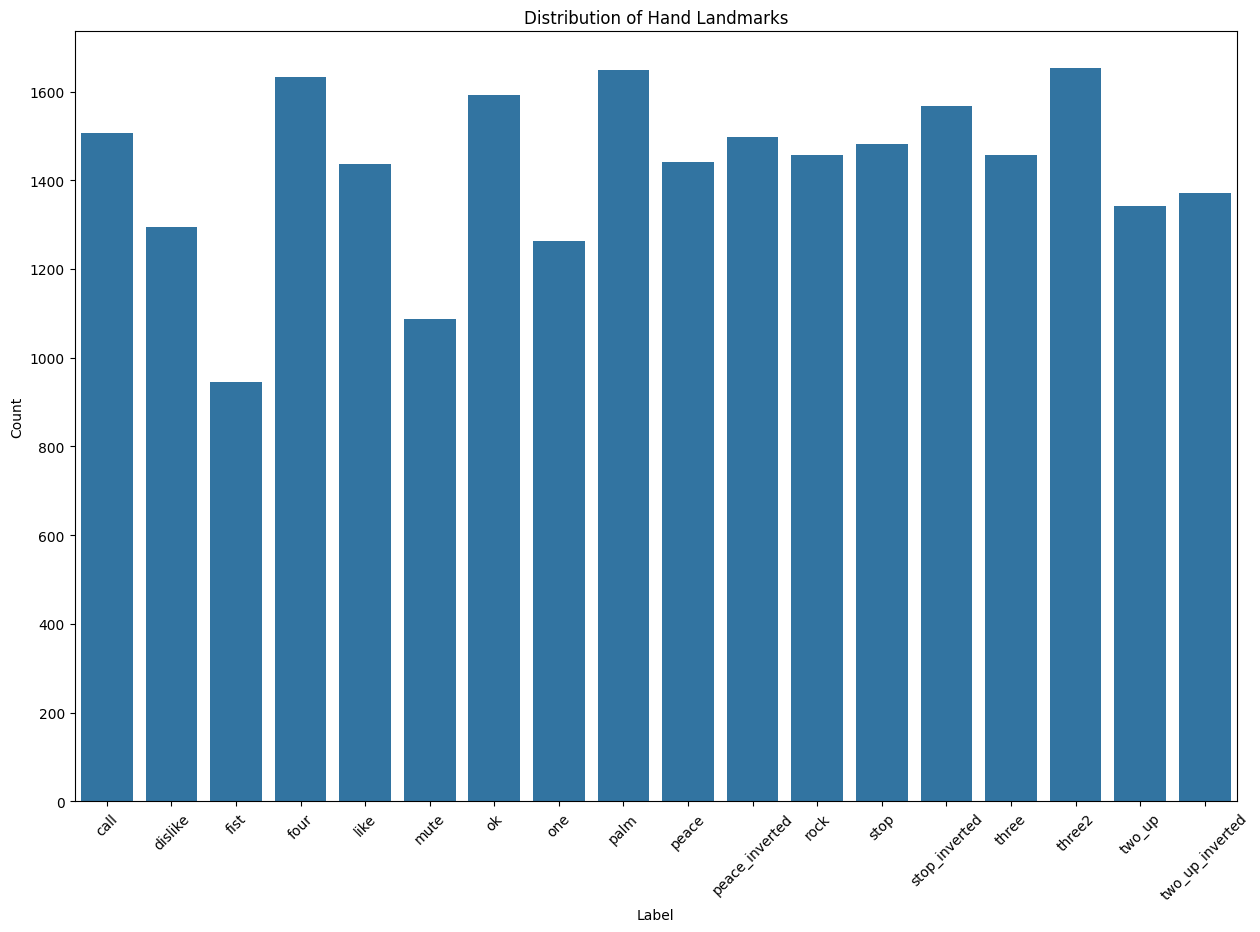

In [5]:
# checking the distribution of the 'label' column
fig = plt.figure(figsize=(15, 10))
sns.countplot(x='label', data=df)
plt.title('Distribution of Hand Landmarks')
plt.xlabel('Label')
plt.ylabel('Count') 
plt.xticks(rotation=45)
plt.show()

In [6]:
df['label'].value_counts()

label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64

### 2- Landmarks visualization


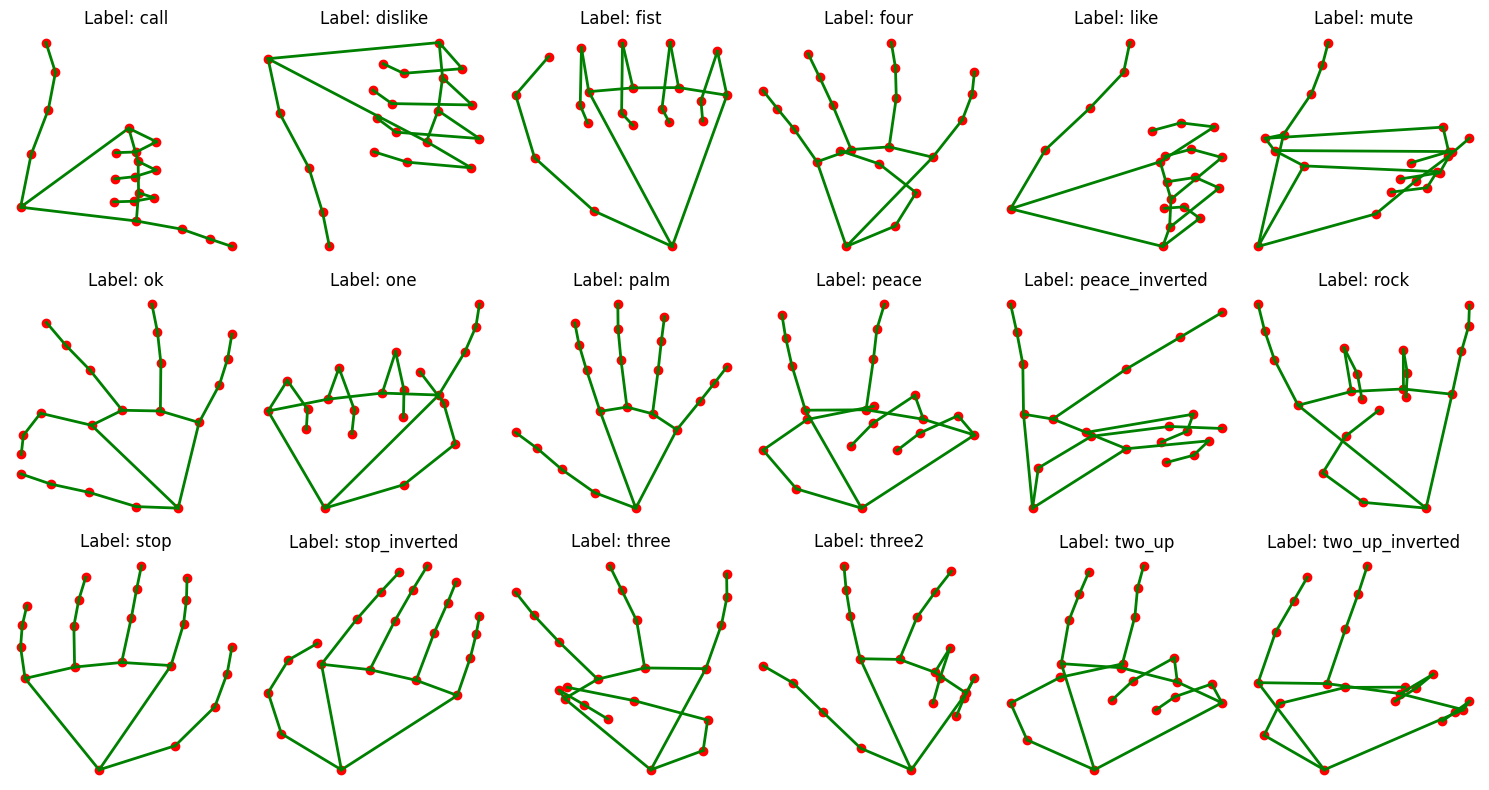

In [7]:
# ploting random sample of each gesture
sampled_df = df.groupby("label").sample().reset_index()
num_landmarks = 21
edges = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),  # Index
    (0, 17), (17, 18), (18, 19), (19, 20),  # Pinky
    (5, 9), (9, 10), (10, 11), (11, 12),  # Middle
    (9, 13), (13, 14), (14, 15), (15, 16),  # Ring
    (13, 17)  # Palm base connection
]
fig, axes = plt.subplots(3, 6, figsize=(15, 8))  # Adjust grid based on the number of labels
axes = axes.flatten() 
for i, row in sampled_df.iterrows():
    ax = axes[i]

    x_values = [row[f"x{j+1}"] for j in range(num_landmarks)]
    y_values = [row[f"y{j+1}"] for j in range(num_landmarks)]
    ax.scatter(x_values, y_values, color='red', label="Landmarks")
    for edge in edges:
        x_start, y_start = x_values[edge[0]], y_values[edge[0]]
        x_end, y_end = x_values[edge[1]], y_values[edge[1]]
        ax.plot([x_start, x_end], [y_start, y_end], color="green", linewidth=2)

    # Annotate gesture label
    ax.set_title(f"Label: {row['label']}")
    ax.invert_yaxis()
    ax.axis("off")

plt.tight_layout()
plt.show()


### 3- Data Normalization and Preprocessing


In [8]:
# normilizing the landmarks data by the distance between the wrist and the middle finger and subtracting the wrist position
def normalize_landmarks(row):
    wrist_x, wrist_y = row["x1"], row["y1"]
    mid_finger_x, mid_finger_y = row["x13"], row["y13"]
    scale = np.sqrt((mid_finger_x - wrist_x) ** 2 + (mid_finger_y - wrist_y) ** 2)
    # Avoid division by zero
    if scale == 0:
        scale = 1
    for i in range(num_landmarks):
        row[f"x{i+1}"] = (row[f"x{i+1}"] - wrist_x) / scale
        row[f"y{i+1}"] = (row[f"y{i+1}"] - wrist_y) / scale

    return row
# Apply normalization
df_normalized = df.apply(normalize_landmarks, axis=1)

In [9]:
df_normalized.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,0.0,0.0,-3.649205e-07,-0.169097,-0.328246,0.004224,-0.508248,-0.501843,0.005798,-0.846234,...,-1.266027,-0.058407,-0.020450,-1.533293,0.026072,-0.024577,-1.759842,0.074168,-0.026722,call
1,0.0,0.0,-2.345265e-07,-0.040618,-0.498120,-0.011102,0.191551,-0.982869,-0.021096,0.349889,...,1.397837,-0.121412,-0.038175,1.691695,-0.091952,-0.037336,1.966655,-0.086635,-0.036136,call
2,0.0,0.0,-2.417307e-07,0.172978,-0.420554,-0.000184,0.437913,-0.820949,-0.009687,0.621006,...,1.404373,0.187884,-0.044068,1.676609,0.247919,-0.040469,1.913833,0.270275,-0.038301,call
3,0.0,0.0,-1.233261e-07,-0.020056,-0.468103,-0.002824,0.070355,-0.911821,-0.008911,0.114792,...,1.280797,-0.094800,-0.027622,1.529073,-0.079763,-0.027863,1.738331,-0.086693,-0.027723,call
4,0.0,0.0,-1.622995e-07,-0.009611,-0.482677,-0.002884,0.111650,-1.075914,-0.008115,0.131602,...,1.327537,-0.331511,-0.025113,1.612488,-0.386821,-0.024087,1.849127,-0.464123,-0.023486,call


In [10]:
# label encoding from 18 string labels to numbers [0:17]
label_encoder = LabelEncoder()

df_normalized["label_encoded"] = label_encoder.fit_transform(df_normalized["label"])

# Check encoding
print(df_normalized[["label", "label_encoded"]].head())

#decoded_label = label_encoder.inverse_transform([0])  # Converts 0 back to original label


  label  label_encoded
0  call              0
1  call              0
2  call              0
3  call              0
4  call              0


In [11]:
#drop the label column
df_normalized.drop(columns=["label"], inplace=True)
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x1             25675 non-null  float64
 1   y1             25675 non-null  float64
 2   z1             25675 non-null  float64
 3   x2             25675 non-null  float64
 4   y2             25675 non-null  float64
 5   z2             25675 non-null  float64
 6   x3             25675 non-null  float64
 7   y3             25675 non-null  float64
 8   z3             25675 non-null  float64
 9   x4             25675 non-null  float64
 10  y4             25675 non-null  float64
 11  z4             25675 non-null  float64
 12  x5             25675 non-null  float64
 13  y5             25675 non-null  float64
 14  z5             25675 non-null  float64
 15  x6             25675 non-null  float64
 16  y6             25675 non-null  float64
 17  z6             25675 non-null  float64
 18  x7    

In [12]:
df_normalized['label_encoded'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [13]:
# checking the labels and inverse transform
label_encoder.inverse_transform(df_normalized['label_encoded'].unique())

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
       'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted',
       'three', 'three2', 'two_up', 'two_up_inverted'], dtype=object)

In [14]:
# splitting the dataset into features and labels
features = df_normalized.drop(["label_encoded"], axis=1)
labels = df_normalized["label_encoded"]

In [15]:
features.shape

(25675, 63)

In [16]:
labels.shape

(25675,)

In [17]:
# Splitting the dataset into training and validation/test sets
# 60% training, 40% validation/test
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
    features, labels, test_size=0.4, random_state=100)

In [18]:
# Splitting the validation/test set into two equal parts
features_validation, features_test, labels_validation, labels_test = train_test_split(
    features_validation_test, labels_validation_test, test_size=0.5, random_state=100)

In [19]:
print(len(features_train))
print(len(features_validation))
print(len(features_test))
print(len(labels_train))
print(len(labels_validation))
print(len(labels_test))

15405
5135
5135
15405
5135
5135


### 4- Training Different Models, Chosing the best one


In [20]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(multi_class="multinomial")
lr_model.fit(features_train,labels_train)
lr_model_score = lr_model.score(features_validation,labels_validation)

/Users/mohamedkorayem/anaconda3/envs/ITI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/mohamedkorayem/anaconda3/envs/ITI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Train decision tree model
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(features_train,labels_train)
dt_model_score = dt_model.score(features_validation,labels_validation)

In [22]:
# Train SVM model
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(features_train,labels_train)
svm_model_score = svm_model.score(features_validation,labels_validation)

In [23]:
# Train random forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(features_train,labels_train)
rf_model_score = rf_model.score(features_validation,labels_validation)

In [24]:
# Train gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(features_train,labels_train)
gb_model_score = gb_model.score(features_validation,labels_validation)

In [25]:
# Train Adaboost model
from sklearn.ensemble import AdaBoostClassifier
ab_model = AdaBoostClassifier()
ab_model.fit(features_train,labels_train)
ab_model_score = ab_model.score(features_validation,labels_validation)

/Users/mohamedkorayem/anaconda3/envs/ITI/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [26]:
# print accuracy of each model on validation data
print("Scores of the models",)
print("Logistic regression:",lr_model_score)
print("Decision tree:",dt_model_score )
print("SVM:", svm_model_score)
print("Random forest:",rf_model_score )
print("Gradient boosting:",gb_model_score )
print("AdaBoost:",ab_model_score )

Scores of the models
Logistic regression: 0.8385589094449853
Decision tree: 0.9466407010710808
SVM: 0.9180136319376826
Random forest: 0.9776046738072055
Gradient boosting: 0.9750730282375852
AdaBoost: 0.1851996105160662


In [27]:
from sklearn.metrics import recall_score, precision_score
print("Precision of the models",)
print("Logistic regression:",precision_score(labels_validation, lr_model.predict(features_validation),average='weighted'))
print("Decision tree:",precision_score(labels_validation, dt_model.predict(features_validation),average='weighted'))
print("SVM:", precision_score(labels_validation, svm_model.predict(features_validation),average='weighted'))
print("Random forest:",precision_score(labels_validation, rf_model.predict(features_validation),average='weighted'))
print("Gradient boosting:",precision_score(labels_validation, gb_model.predict(features_validation),average='weighted'))
print("AdaBoost:",precision_score(labels_validation, ab_model.predict(features_validation),average='weighted'))

Precision of the models
Logistic regression: 0.8396808319136294
Decision tree: 0.9471315287995105
SVM: 0.9196804261446018
Random forest: 0.9776883237774505
Gradient boosting: 0.9751726065651087
AdaBoost: 0.16814144030120964


/Users/mohamedkorayem/anaconda3/envs/ITI/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
print("Recall of the models",)
print("Logistic regression:",recall_score(labels_validation, lr_model.predict(features_validation),average='weighted'))
print("Decision tree:",recall_score(labels_validation, dt_model.predict(features_validation),average='weighted'))
print("SVM:", recall_score(labels_validation, svm_model.predict(features_validation),average='weighted'))
print("Random forest:",recall_score(labels_validation, rf_model.predict(features_validation),average='weighted'))
print("Gradient boosting:",recall_score(labels_validation, gb_model.predict(features_validation),average='weighted'))
print("AdaBoost:",recall_score(labels_validation, ab_model.predict(features_validation),average='weighted'))

Recall of the models
Logistic regression: 0.8385589094449853
Decision tree: 0.9466407010710808
SVM: 0.9180136319376826
Random forest: 0.9776046738072055
Gradient boosting: 0.9750730282375852
AdaBoost: 0.1851996105160662


In [29]:
# print F1-score of each model on validation data
from sklearn.metrics import f1_score
print("F1-scores of the models:")
lr_f1=f1_score(labels_validation,lr_model.predict(features_validation),average='weighted')
print("Logistic regression:",lr_f1 )
dt_f1=f1_score(labels_validation,dt_model.predict(features_validation),average='weighted')
print("Decision tree:",dt_f1 )
svm_f1=f1_score(labels_validation,svm_model.predict(features_validation),average='weighted')
print("SVM:",svm_f1 )
rf_f1=f1_score(labels_validation,rf_model.predict(features_validation),average='weighted')
print("Random forest:",rf_f1 )
gb_f1=f1_score(labels_validation,gb_model.predict(features_validation),average='weighted')
print("Gradient boosting:",gb_f1 )
ab_f1=f1_score(labels_validation,ab_model.predict(features_validation),average='weighted')
print("AdaBoost:",ab_f1 )

F1-scores of the models:
Logistic regression: 0.836106372257509
Decision tree: 0.9467338084235088
SVM: 0.917688345846663
Random forest: 0.9776045001075503
Gradient boosting: 0.9750659709116075
AdaBoost: 0.09973064215297643


##### best model Random Forest Model


In [30]:
#rf_model
# Prediction score on test data
print("Random forest (score):",rf_model.score(features_test,labels_test))
rf_f1=f1_score(labels_test,rf_model.predict(features_test),average='weighted')
print("Random forest (f1):",rf_f1 )
rf_precision=precision_score(labels_test, rf_model.predict(features_test),average='weighted')
print("Random forest (precision):",rf_precision )
rf_recall=recall_score(labels_test, rf_model.predict(features_test),average='weighted')
print("Random forest (recall):",rf_recall )

Random forest (score): 0.9740993184031159
Random forest (f1): 0.9741046902073094
Random forest (precision): 0.9742220711756483
Random forest (recall): 0.9740993184031159


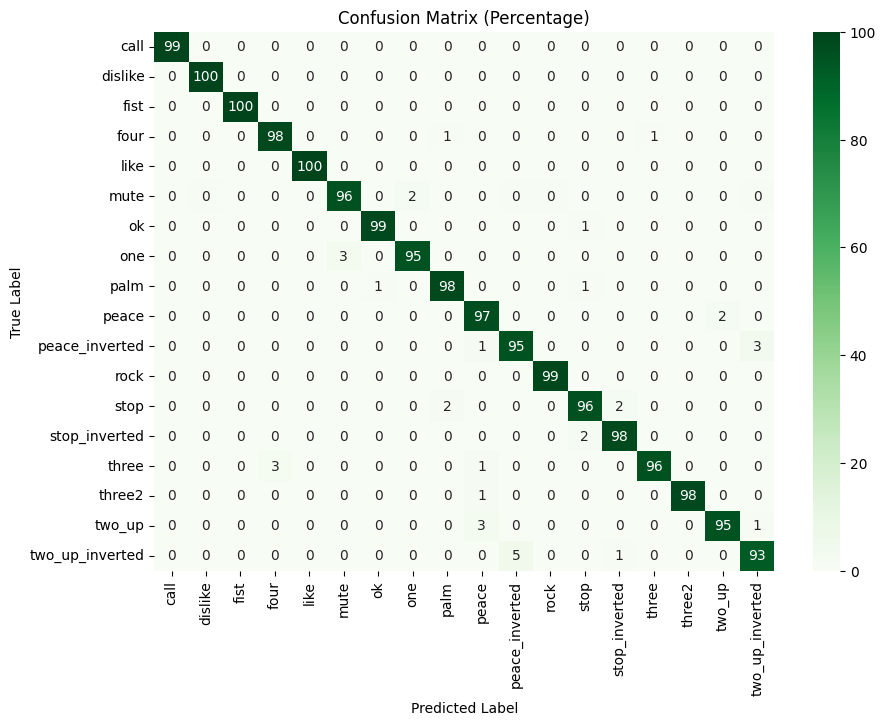

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = rf_model.predict(features_test)

# Compute confusion matrix
cm = confusion_matrix(labels_test, y_pred)

cm_percentage = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True) * 100  # Normalize per class

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".0f", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [32]:
# save model as pkl file
import joblib
joblib.dump(rf_model,"rf_model.pkl")

['rf_model.pkl']

<h3><center>training results<center><h3>


## From the metrics and the confusion matrix it is shown that the random forest model preforms the best

### Now we move from model training to model inference

#### first we need to use media pipe to extract the key points

#### then the data must pass through the same "pipeline" before making predictions


### 5- Model Loading & Inference


In [33]:
#load model
import joblib
rf_model=joblib.load("rf_model.pkl")

In [34]:
# import mediapipe, load hand landmark model, and drawing utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,  # For video, set to False
                        max_num_hands=1,         # Detect one hand
                        min_detection_confidence=0.5, 
                        min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1743779301.352727  482230 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1


In [35]:
# function to normalize landmarks before inference as part of the pipline
def normalize_landmarks(landmarks):
    """Normalize hand landmarks by setting wrist as origin and scaling by distance to middle finger tip."""
    wrist = np.array([landmarks[0][0], landmarks[0][1]])  # Wrist (x0, y0)
    middle_tip = np.array([landmarks[12][0], landmarks[12][1]])  # Middle finger tip (x12, y12)

    # Compute scaling factor (Euclidean distance between wrist & middle finger tip)
    scale = np.linalg.norm(wrist - middle_tip)
    if scale == 0:  # Prevent division by zero
        scale = 1

    # Normalize landmarks
    norm_landmarks = [( (x - wrist[0]) / scale, (y - wrist[1]) / scale, z / scale ) for x, y, z in landmarks]
    return norm_landmarks

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [37]:
#visualization & prediction loop
predictions = []
window_size = 10
column_names = []
for i in range(1, 22):
    column_names.append(f"x{i}")
    column_names.append(f"y{i}")
    column_names.append(f"z{i}") 
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Convert frame to RGB (MediaPipe requires RGB format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Process frame with MediaPipe
    results = hands.process(rgb_frame)
    # Default prediction in case no hand is detected
    predicted_label = "No Hand Detected"
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
            norm_landmarks = normalize_landmarks(landmarks)
            if norm_landmarks:
                flat_landmarks = np.array(norm_landmarks).flatten().reshape(1, -1)
                rf_model_input = pd.DataFrame(flat_landmarks, columns=column_names)
                prediction = rf_model.predict(rf_model_input)
                predicted_label = label_encoder.inverse_transform(prediction)[0]
                predictions.append(predicted_label)
                # Keep the predictions list size within the window size
                if len(predictions) > window_size:
                    predictions.pop(0)
        prediction_mode = Counter(predictions).most_common(1)[0][0]
        prediction_mode = predicted_label
        mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        # Display the mode of predictions
        cv2.putText(frame, f'Predicted Mode: {prediction_mode}', (75, 75), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 3)

    # Show the frame with prediction
    cv2.imshow("Hand Gesture Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

2025-04-04 17:08:43.651 python[16702:482230] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-04 17:08:43.651 python[16702:482230] +[IMKInputSession subclass]: chose IMKInputSession_Modern
W0000 00:00:1743779329.021941  486015 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-1

# Notebook Summary

## Objective:

The notebook focuses on building a hand gesture classification system using the HaGRID dataset and MediaPipe. The workflow includes data exploration, preprocessing, model training, evaluation, and real-time inference.

## Workflow:

1. **Data Exploration**:

   - The dataset is loaded and explored to understand its structure and label distribution.
   - Visualizations such as count plots are used to analyze the label distribution.

2. **Landmarks Visualization**:

   - Hand landmarks are visualized using scatter plots and connections to understand the spatial structure of the data.

3. **Data Normalization and Preprocessing**:

   - Hand landmarks are normalized by setting the wrist as the origin and scaling based on the distance to the middle finger tip.
   - Labels are encoded using `LabelEncoder` for compatibility with machine learning models.

4. **Model Training and Evaluation**:

   - Multiple models (Logistic Regression, Decision Tree, SVM, Random Forest, Gradient Boosting, AdaBoost) are trained and evaluated.
   - Metrics such as accuracy, precision, recall, and F1-score are used to compare model performance.
   - The Random Forest model is identified as the best-performing model.

5. **Model Deployment and Inference**:
   - The Random Forest model is saved using `joblib` and loaded for inference.
   - MediaPipe is used to extract real-time hand landmarks from video input.
   - Predictions are made in real-time and displayed on video frames.
